<a href="https://colab.research.google.com/github/pastrop/kaggle/blob/master/Tabular_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#package for the data profiling
%%capture
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [1]:
#package for encoding categorical predictors
%%capture
pip install category_encoders

In [2]:
#require pip install above
from pandas_profiling import ProfileReport

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce #require pip install above
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Prep

**Run the utulity functions defined below**



*   def get_dummies_col(df, col)
*   def get_hushes(df, cols)
*   def train_test_split_custom(X,Y)






In [4]:
# file upload while using Google Colab
from google.colab import files
uploaded = files.upload()

Saving nomad.csv to nomad.csv


In [ ]:
# Load Dataframe Test Set: assume nomad.csv as input file name
df = pd.read_csv('nomad.csv')
#df.head(3)

In [6]:
 #Dataframe Stats - Test Set
 print(f'df.shape - {df.shape}')
 #df.describe() 

df.shape - (4813, 20)


In [ ]:
# Basic Data Quality Check - Test Set
df.isnull().sum()

User  ID                                            0
User Registered Date                                0
User Num References                                 0
User Num Qualified References                       0
User Num Completed PCLs                             0
User Num State Licenses                             0
User Has Compact License (Yes / No)                 0
User Count Applications Completed last 7 Days     179
User Count Applications Completed last 30 Days    179
User Count Applications Completed                 179
User Count Jobs Viewed, last 30 Days                0
User Certifications                                 9
User EHR Systems                                   22
User Specialization List                          376
User Age Bucket                                     0
User Years Nursing Exp                            115
User Years Travel Exp                             564
User First Application Date                       180
User Last Application Date  

In [7]:
# I made a decision to drop all rows with NaN values since it is unclear how to impute those - Test Set
df_cleaned = df.dropna()
df_cleaned.shape

(3761, 20)

In [ ]:
#df_cleaned[df_cleaned['User Count Offered']==1].count()

In [ ]:
# Data Profiling for the In-depth Exploration
#profile = ProfileReport(df_cleaned, title='Data Profiling Report', html={'style':{'full_width':False}})
#profile.to_notebook_iframe()

In [ ]:
df_cleaned.columns #service code to get a list of column, for cut and paste, not needed for anything else

Index(['User  ID', 'User Registered Date', 'User Num References',
       'User Num Qualified References', 'User Num Completed PCLs',
       'User Num State Licenses', 'User Has Compact License (Yes / No)',
       'User Count Applications Completed last 7 Days',
       'User Count Applications Completed last 30 Days',
       'User Count Applications Completed',
       'User Count Jobs Viewed, last 30 Days', 'User Certifications',
       'User EHR Systems', 'User Specialization List', 'User Age Bucket',
       'User Years Nursing Exp', 'User Years Travel Exp',
       'User First Application Date', 'User Last Application Date',
       'User Count Offered'],
      dtype='object')

In [8]:
# Dataframe of Original Numeric Predictors (dropping all categorical data & target for the follow-up processing):
X_original = df_cleaned.drop(['User  ID', 'User Registered Date','User Has Compact License (Yes / No)','User Certifications', 
                              'User EHR Systems','User Specialization List','User Age Bucket', 'User First Application Date', 
                              'User Last Application Date','User Count Offered' ], axis=1) 
X_original.shape #sanity check

(3761, 10)

In [9]:
#Target Dataframe:
Y = df_cleaned['User Count Offered']

In [14]:
df_dummies = get_dummies_col(df_cleaned, col = 'User Has Compact License (Yes / No)')
df_hash_encoded = get_hushes(df_cleaned, cols = ['User Certifications', 'User EHR Systems','User Specialization List'])

In [15]:
# new numeric parameters frame
df_new_variables = pd.concat([df_hash_encoded,df_dummies],axis=1)

In [16]:
# Dataframe of Predictors:
X = pd.concat([X_original,df_new_variables], axis=1)
X.head(3)
# col_0 through Col_7 are the result of hashing 'User Certifications', 'User EHR Systems' and 'User Specialization List'
# categorical series, those parameters can not be interpreted independentaly, these are embeddings via hashing
# this element of data paremetrization should be researched further as a part of the feature engineering for the any model 
# planned for Prod

,User Num References,User Num Qualified References,User Num Completed PCLs,User Num State Licenses,User Count Applications Completed last 7 Days,User Count Applications Completed last 30 Days,User Count Applications Completed,"User Count Jobs Viewed, last 30 Days",User Years Nursing Exp,User Years Travel Exp,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,No,Yes
0,3,2,1,1,0.0,0.0,1.0,18,11.0,0.0,1,1,0,0,0,0,0,1,0,1
1,3,2,1,1,0.0,0.0,1.0,1,6.0,0.0,0,1,0,0,0,0,2,0,0,1
2,4,3,3,2,0.0,0.0,6.0,0,14.0,3.0,2,1,0,0,0,0,0,0,0,1


In [17]:
X.shape

(3761, 20)

In [18]:
 X_train_rescaled, X_test_rescaled, y_train, y_test = train_test_split_custom(X,Y)

In [19]:
X_train_rescaled.shape # sanity check

(3572, 20)

**Data Prep Findings**


*   The Target - 'User Count Offered' appears to  have only 2 classes [0,1].  Therefore the below model is a binary classifier.  It won't be difficult to change it to the multi-class  
*   The following data series are excluded from the model parameters: 'User  ID', 'User Registered Date' (for obvious reasons, these 2 shouldn't affect the result), 'User Age Bucket' (I hope it doesn't affect the result. if it does,  there is an age-bias in this industry, it is an example of a "protected variable", models should in insensitive to it), 'User First Application Date', 'User Last Application Date' (it may be researched further, in a real world scenario, I would talk to the product management to understand how this data may influence the classification, without this knowledge it is not clear to me what is the most appropriate way of casting these parameters into numeric values.  Without this understanding it may skew the results)



# Modelling

In [20]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

In [21]:
# Imports for Kfold cross validation 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

*XGBoost*

In [26]:
# fit model to training data
model_XGB = XGBClassifier()
model_XGB.fit(X_train_rescaled, y_train)
# feature importance
features_xgb = model_XGB.feature_importances_
print(features_xgb) # Relative importance of the features

[0.0269777  0.16255695 0.07531682 0.03323105 0.0265331  0.01949844
 0.28515694 0.09012117 0.02345294 0.0334481  0.02912311 0.03162127
 0.01557791 0.03620308 0.01792753 0.0294485  0.02695657 0.01936318
 0.01748566 0.        ]


In [85]:
%matplotlib inline

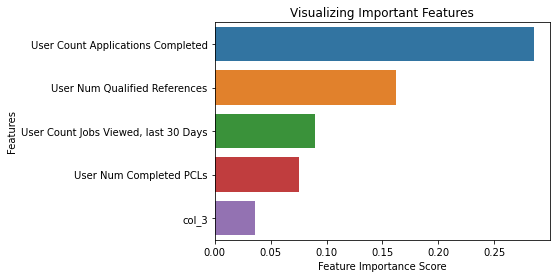

In [87]:
feature_importances = sorted(zip(features_xgb,list(X.columns)), reverse = True)[:5]; feature_importances
# Plotting Feature Importances
feature_imp = [item[0] for item in feature_importances]
feature_imp_index = [item[1] for item in feature_importances]
sns.barplot(x=feature_imp, y=feature_imp_index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
#plt.legend()
plt.show()
# Features titled as col_X are hashes of the categircal features (see above).  The embedding methods should be tested further 
# for Production models to determine its impact on model performance 

*Prediction & Accuracy. <br> Preprocess & Scale parameters before running model predictions*

In [27]:
# make predictions for test data
y_pred = model_XGB.predict(X_test_rescaled)
accuracy = accuracy_score(y_test, y_pred); accuracy

0.8465608465608465

*K-folds Cross Valiation (making sure that 85% accuracy is not too good to be true...)*

In [29]:
# Data Prep for K-folds Cross Validation
scaler = StandardScaler().fit(X.values)
X_kfolds_rescaled = scaler.transform(X.values)

#X_kfolds_rescaled = scaler.transform(X_with_time.values)

y_kfold = Y.values

In [89]:
%%capture
kfold = KFold(n_splits=10, random_state=42)
results = cross_val_score(model_XGB, X_kfolds_rescaled, y_kfold, cv=kfold)

In [90]:
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 81.86% (6.07%)


*Random Forest*

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
clf = RandomForestClassifier(max_depth=10, random_state=42)
clf.fit(X_train_rescaled, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [34]:
y_pred_clf = clf.predict(X_test_rescaled)
accuracy = accuracy_score(y_test, y_pred_clf); accuracy

0.8518518518518519

In [35]:
# feature importance
features_clf = clf.feature_importances_
print(features_clf) # Relative importance of the features

[0.05582591 0.11999596 0.11338952 0.03429352 0.00680144 0.031601
 0.28782463 0.11379947 0.05573012 0.04315291 0.01527735 0.0150033
 0.01773135 0.01694974 0.0144776  0.01362007 0.01648423 0.01424182
 0.00617282 0.00762722]


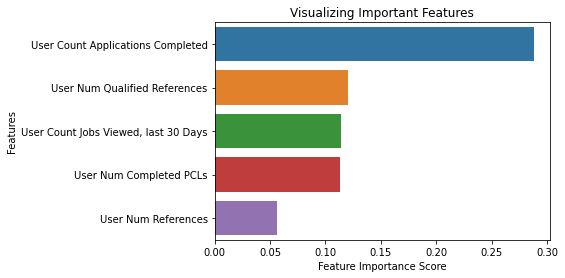

In [88]:
feature_importances = sorted(zip(features_clf,list(X.columns)), reverse = True)[:5]; feature_importances
# Plotting Feature Importances
feature_imp = [item[0] for item in feature_importances]
feature_imp_index = [item[1] for item in feature_importances]
sns.barplot(x=feature_imp, y=feature_imp_index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")#plt.legend()
plt.show()
# Features titled as col_X are hashes of the categircal features (see above).  The embedding methods should be tested further 
# for Production models to determine its impact on model performance 

# Processing the Validation Dataset

In [ ]:
# Load Dataframe Validation Set: assume nomad.csv as input file name
df_val = pd.read_csv('Validation _ Q4_2020.csv')

In [ ]:
 #Dataframe Stats - Validation Set
 df_val=df_val.drop(['User Count Offered'],axis = 1)
 print(f'df.shape - {df_val.shape}')
 df_val.describe()

df.shape - (479, 19)


,User Num References,User Num Qualified References,User Num Completed PCLs,User Num State Licenses,User Count Applications Completed last 7 Days,User Count Applications Completed last 30 Days,User Count Applications Completed,"User Count Jobs Viewed, last 30 Days",User Years Nursing Exp,User Years Travel Exp
count,479.000000,479.000000,479.000000,479.000000,457.000000,457.000000,457.000000,479.000000,460.000000,421.000000
mean,3.482255,1.812109,0.931106,1.405010,0.048140,1.017505,2.671772,3.716075,12.334783,1.123515
std,0.939152,1.191927,0.949264,1.780548,0.340732,2.009768,2.959065,6.906941,93.559651,1.873104
min,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,3.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,3.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,6.000000,0.000000
75%,4.000000,3.000000,1.000000,1.000000,0.000000,1.000000,3.000000,5.000000,10.000000,1.000000
max,11.000000,6.000000,8.000000,36.000000,5.000000,14.000000,27.000000,54.000000,2009.000000,14.000000


In [ ]:
# Basic Data Quality Check - Test Set
df_val.isnull().sum()

User  ID                                           0
User Registered Date                               0
User Num References                                0
User Num Qualified References                      0
User Num Completed PCLs                            0
User Num State Licenses                            0
User Has Compact License (Yes / No)                0
User Count Applications Completed last 7 Days     22
User Count Applications Completed last 30 Days    22
User Count Applications Completed                 22
User Count Jobs Viewed, last 30 Days               0
User Certifications                                2
User EHR Systems                                   1
User Specialization List                          74
User Age Bucket                                    0
User Years Nursing Exp                            19
User Years Travel Exp                             58
User First Application Date                       22
User Last Application Date                    

In [ ]:
# I made a decision to drop all rows with NaN values since it is unclear how to impute those Valdation Set
df_val_cleaned = df_val.dropna()
df_val_cleaned.shape

(332, 19)

In [ ]:
df_val_cleaned.head(3)

,User ID,User Registered Date,User Num References,User Num Qualified References,User Num Completed PCLs,User Num State Licenses,User Has Compact License (Yes / No),User Count Applications Completed last 7 Days,User Count Applications Completed last 30 Days,User Count Applications Completed,"User Count Jobs Viewed, last 30 Days",User Certifications,User EHR Systems,User Specialization List,User Age Bucket,User Years Nursing Exp,User Years Travel Exp,User First Application Date,User Last Application Date
0,5fb0706c76c4db4bc50a5341,2020-11-14,4,3,1,1,Yes,0.0,3.0,3.0,3,ACLS-BLS,Cerner-Meditech,Medical Surgical - Telemetry,35-39,11.0,1.0,2020-11-14,2020-11-24
1,5fafdb72c636ae9a743d0868,2020-11-14,4,3,1,1,No,0.0,1.0,1.0,12,ACLS-BLS-PALS,Epic-Meditech,"Medical Surgical - Telemetry, Step-Down",Minus 25,1.0,0.0,2020-11-14,2020-11-14
2,5faf7dba0db563f8031a975b,2020-11-14,3,1,0,1,Yes,0.0,1.0,1.0,5,ACLS,Cerner,"Step-Down, Medical-Surgical, Intermediate Care",30-34,1.0,0.0,2020-11-14,2020-11-14


**Validation Data Prep**

In [ ]:
# Dataframe of Original Numeric Predictors (dropping all categorical data & target for the follow-up processing) - Validation Set:
X_original_val = df_val_cleaned.drop(['User  ID', 'User Registered Date','User Has Compact License (Yes / No)','User Certifications', 
                              'User EHR Systems','User Specialization List','User Age Bucket', 'User First Application Date', 
                              'User Last Application Date'], axis=1) 

In [ ]:
X_original_val.shape

(332, 10)

In [ ]:
# transforming categorical data
# conversion to dummies for low cardinality variables
df_to_dummies_val = df_val_cleaned['User Has Compact License (Yes / No)']
df_dummies_val = pd.get_dummies(df_to_dummies_val, columns=['User Has Compact License (Yes / No)'])
# conversion to hashes for high cordinality variables
# default settings are used. Depending the relative business importance of these parameters it may be refined further during feature engineering 
df_to_hush_transform_val = df_val_cleaned[['User Certifications', 'User EHR Systems','User Specialization List']]
hash_encoder_val = ce.HashingEncoder()
df_hash_encoded_val = hash_encoder_val.fit_transform(df_to_hush_transform_val)
# new numeric parameters frame
df_new_variables_val = pd.concat([df_hash_encoded_val,df_dummies_val],axis=1)

In [ ]:
# Dataframe of Predictors - Validation Set:
X_val = pd.concat([X_original_val,df_new_variables_val], axis=1)
X_val.head(3)
# col_0 through Col_7 are the result of hashing 'User Certifications', 'User EHR Systems' and 'User Specialization List'
# categorical series, those parameters can not be interpreted independentaly, these are embeddings via hashing
# this element of data paremetrization should be researched further as a part of the feature engineering for the any model 
# planned for Prod

,User Num References,User Num Qualified References,User Num Completed PCLs,User Num State Licenses,User Count Applications Completed last 7 Days,User Count Applications Completed last 30 Days,User Count Applications Completed,"User Count Jobs Viewed, last 30 Days",User Years Nursing Exp,User Years Travel Exp,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,No,Yes
0,4,3,1,1,0.0,3.0,3.0,3,11.0,1.0,0,0,1,1,0,0,0,1,0,1
1,4,3,1,1,0.0,1.0,1.0,12,1.0,0.0,1,0,0,1,0,0,1,0,1,0
2,3,1,0,1,0.0,1.0,1.0,5,1.0,0.0,0,0,1,0,0,0,2,0,0,1


In [ ]:
# Data Prep for K-folds Cross Validation
X_val_rescaled = scaler.transform(X_val.values)

In [ ]:
X_val_rescaled.shape

(332, 20)

In [ ]:
y_pred_validation = model_XGB.predict(X_val_rescaled); y_pred_validation

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,

# Utility Functions

In [11]:
def get_dummies_col(df, col = None):
  # conversion to dummies for low cardinality variables
  df_to_dummies = df_cleaned[col]
  df_dummies = pd.get_dummies(df_to_dummies, columns=[col])
  return df_dummies

In [12]:
def get_hushes(df, cols = []):
  # conversion to hashes for high cordinality variables 
  df_to_hush_transform = df_cleaned[cols]
  hash_encoder = ce.HashingEncoder()
  df_hash_encoded = hash_encoder.fit_transform(df_to_hush_transform)
  # new numeric parameters frame
  return df_hash_encoded

In [13]:
def train_test_split_custom(X,Y):
  # Predictors variables to Numpy arrays following by scaling
  #Train-Test Split
  X_train, X_test, y_train, y_test = train_test_split(X.values, Y.values, test_size=0.05, random_state=42)
  #X_train, X_test, y_train, y_test = train_test_split(X_with_time.values, Y.values, test_size=0.05, random_state=42)

  # Using Standard Scaler 
  scaler = StandardScaler().fit(X.values)
  #scaler = StandardScaler().fit(X_with_time.values)

  X_train_rescaled = scaler.transform(X_train)
  X_test_rescaled = scaler.transform(X_test)
  return X_train_rescaled, X_test_rescaled, y_train, y_test

# Test & Debugging Related Code Snippets

In [ ]:
#datetime columns experimentation:
%%capture
df_time = df_cleaned[['User Registered Date','User First Application Date','User Last Application Date']]
df_time['User Registered Date'] = pd.to_datetime(df_time['User Registered Date'])
df_time['User First Application Date'] = pd.to_datetime(df_time['User First Application Date'])
df_time['User Last Application Date'] = pd.to_datetime(df_time['User Last Application Date'])
df_time['1st_time_delta'] = (df_time['User First Application Date']-df_time['User Registered Date']).astype('timedelta64[D]')
df_time['2nd_time_delta'] = (df_time['User Last Application Date']-df_time['User First Application Date']).astype('timedelta64[D]')
df_time_deltas = df_time[['1st_time_delta','2nd_time_delta']]
df_time_deltas.shape

In [ ]:
#X_with_time = pd.concat([X,df_time_deltas],axis = 1)

In [ ]:
# transforming categorical data
# conversion to dummies for low cardinality variables
df_to_dummies = df_cleaned['User Has Compact License (Yes / No)']
df_dummies = pd.get_dummies(df_to_dummies, columns=['User Has Compact License (Yes / No)'])
# conversion to hashes for high cordinality variables
# default settings are used. Depending the relative business importance of these parameters it may be refined further during feature engineering 
df_to_hush_transform = df_cleaned[['User Certifications', 'User EHR Systems','User Specialization List']]
hash_encoder = ce.HashingEncoder()
df_hash_encoded = hash_encoder.fit_transform(df_to_hush_transform)
# new numeric parameters frame
df_new_variables = pd.concat([df_hash_encoded,df_dummies],axis=1)

In [ ]:
# Predictors variables to Numpy arrays following by scaling
#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X.values, Y.values, test_size=0.05, random_state=42)

#X_train, X_test, y_train, y_test = train_test_split(X_with_time.values, Y.values, test_size=0.05, random_state=42)

# Using Standard Scaler 
scaler = StandardScaler().fit(X.values)

#scaler = StandardScaler().fit(X_with_time.values)

X_train_rescaled = scaler.transform(X_train)
X_test_rescaled = scaler.transform(X_test)